In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

## Reconstructing a dataset from DLS
Few lines intro

**Learning objectives:**
1. Construct and use CIL processors Centre of rotation and Resizer to preprocess the data
2. Define the projector
3. Apply different reconstruction techniques to a real dataset

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ccpi.framework import ImageData, ImageGeometry
from ccpi.framework import AcquisitionGeometry, AcquisitionData

from ccpi.optimisation.algorithms import CGLS, SIRT
from ccpi.optimisation.functions import Norm2Sq, L1Norm
from ccpi.optimisation.operators import BlockOperator, Gradient, Identity
from ccpi.framework import BlockDataContainer

from ccpi.processors import Resizer, CenterOfRotationFinder

from ccpi.io import NEXUSDataReader
from ccpi.astra.operators import AstraProjectorSimple , AstraProjector3DSimple
from ccpi.astra.processors import FBP

# All external imports
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import scipy
from utilities import islicer, link_islicer
from utilities import plotter2D


### Read in the dataset

Use the NEXUS data reader to read in a dataset from the Diamond Light Source. The data reader creates the Aquisition data for you with the geometry specified in the file.

CIL also provides a reader for Nikon datasets `NikonDataReader()`.

In [43]:
## Set up a reader object pointing to the Nexus data set
path = os.path.join(sys.prefix, 'share','ccpi','24737_fd_normalised.nxs')
myreader = NEXUSDataReader(nexus_file=path)
data = myreader.load_data()

#Convert the data from intensity to attenuation by taking the negative log
data.log(out=data)
data *= -1

#look at the data object
print(type(data))
print(data)
islicer(data, direction=0, minmax=(0,3))

<class 'ccpi.framework.framework.AcquisitionData'>
Number of dimensions: 3
Shape: (91, 135, 160)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}



interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=90)

#### Centre of Rotation

The Centre of Rotation is the projection of the rotate axis on to the detector. The reconstruction assumes this is in the centre of the detector.

This means we need to reproccess the data by either padding or cropping the projections to achieve this.

The code below reconstucts the same data set with different centre of rotation offsets.

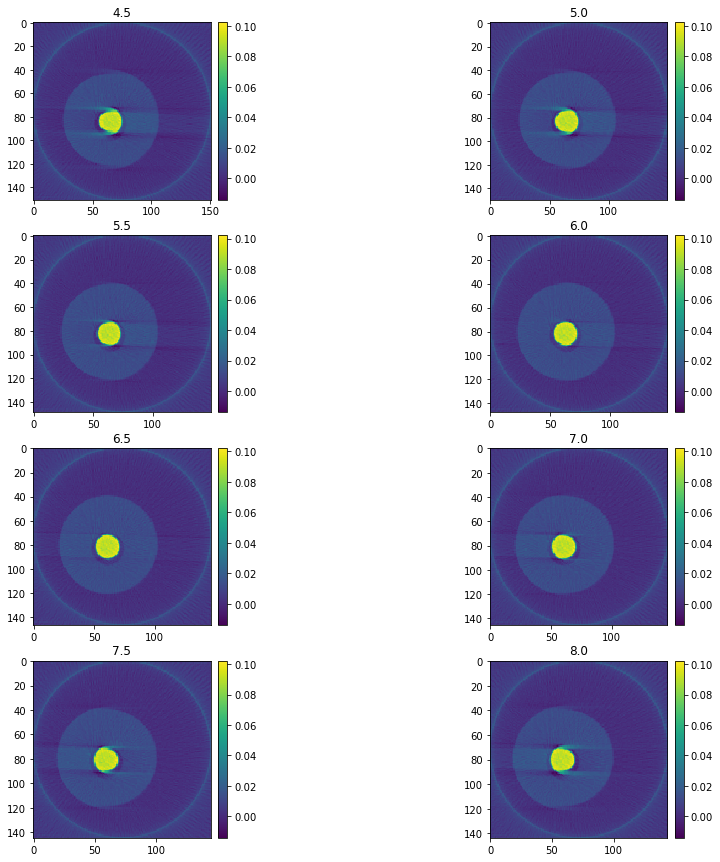

In [4]:
title = []
results = []

data_transposed = data.subset(dimensions=['vertical','angle','horizontal'])
data_transposed.geometry.angles = data.geometry.angles * np.pi /180.

slice_num = 80

for n in range(9,17):
    roi_crop = [-1,-1,(n, data_transposed.shape[2])]
    resizer = Resizer(roi=roi_crop)
    resizer.set_input(data_transposed)
    data_cor = resizer.get_output()

    # Create Acquisition Geometry
    ag = data_cor.geometry.clone()

    # Create Image Geometry
    ig = ImageGeometry(voxel_num_x=ag.pixel_num_h,
                   voxel_num_y=ag.pixel_num_h, 
                   voxel_num_z=ag.pixel_num_v)

    #Initialise the processor
    fbp = FBP(ig, ag, device='gpu')
    fbp.set_input(data_cor)
    FBP_output = fbp.get_output()  

    title.append(n/2)
    results.append(FBP_output.as_array()[slice_num,:,:])

plotter2D(results,title,fix_range=True)

### Use processors to pre-proccess the data

CIL gives you access to some commonly needed data processors including:
- `Normalizer()` normalises AcquisitionData based on the instrument reading with and without incident photons or neutrons
- `Resizer()` allows you to crop or bin the data in any dimension
- `CenterOfRotationFinder()` finds the center of rotation in a parallel beam dataset (credit: Nghia Vo)

The processors are called in the following way:<br>
>processor_instance = Processor(set_up_parameters)<br>
>processor_instance.set_input(data_in)<br>
>data_out = processor_instance.get_output()<br>

### Use CenterOfRotationFinder()

In [5]:
# initialise the processsor
cor = CenterOfRotationFinder()

In [6]:
# set the input data
cor.set_input(data)

In [7]:
# get the output data
center_of_rotation = cor.get_output()
print(center_of_rotation)

86.25


In [9]:
shift = int(((center_of_rotation - data.shape[2]/2)*2)+0.5)
print(shift)

13


### Use Resizer()
Now we'll use `resizer()` to crop the projections to correct for the centre of rotation offset.

`Resizer()` takes the region of interest (roi) as a set up parameter. This is passed as a list where each element defines the behaviour in one dimension. To crop along an axis pass a tuple of the start and end coordinates of the crop, otherwise pass -1.

In [10]:
#define the region of interest
roi_crop = [-1,-1,(shift, data.shape[2])]

In [11]:
#initialise the processsor
resizer = Resizer(roi=roi_crop)

In [12]:
#set the input data
resizer.set_input(data)

In [13]:
#get the output data
data_centred = resizer.get_output()

In [14]:
#Note the acquistion geomerty has also been modified
print(data_centred)
islicer(data_centred, direction=0)

Number of dimensions: 3
Shape: (91, 135, 147)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}



interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=90)

In [15]:
# initialise the processsor
cor = CenterOfRotationFinder()
# set the input data
cor.set_input(data_centred)
# get the output data
center_of_rotation = cor.get_output()
print(center_of_rotation)
shift = int(((center_of_rotation - data_centred.shape[2]/2)*2)+0.5)
print(shift)

73.25
0


### Set up the data ready for ASTRA

ASTRA expects the data in the order `['vertical','angle','horizontal']` so we need to transpose the dataset.

We can use `AcquisitionData.subset()` which returns a subset of the AcquisitionData and regenerates the geometry.

In [16]:
data_processed = data_centred.subset(dimensions=['vertical','angle','horizontal'])
print(data_centred)
print(data_processed)

Number of dimensions: 3
Shape: (91, 135, 147)
Axis labels: {0: 'angle', 1: 'vertical', 2: 'horizontal'}

Number of dimensions: 3
Shape: (135, 91, 147)
Axis labels: {0: 'vertical', 1: 'angle', 2: 'horizontal'}



ASTRA also requires the of projection angles to be in radians. Diamond outputs them in degrees so we need to convert them

In [17]:
#convert the angles to radians
if data_processed.geometry.angle_unit == 'degree':
    data_processed.geometry.angle_unit = 'radian'
    data_processed.geometry.angles = data.geometry.angles * np.pi /180.

In [18]:
#look at the acquisition data
islicer(data_processed, direction=1)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=90), Output()), _dom_cl…

IntSlider(value=0, continuous_update=False, description='x', max=90)

### Define the Geometry

#### Acquistion geometry
In the 2D example we used:<br>
`ag = AcquisitionGeometry(geom_type='parallel', dimension='2D', angles=angles, pixel_num_h=number_pixels_x)`<br>

For 3D we need to change the dimension description to ` dimension='3D'`, and pass the number of vertical pixels as `pixel_num_v`<br>

However we've been using the acquistion geometry throughout this notebook so let's just clone the version we've already set up.

#### Image geometry
In the 2D example we used:<br>
`ig = ImageGeometry(voxel_num_x = num_voxels_xy, voxel_num_y = num_voxels_xy)`

For ad 3D reconstruction we also need to pass the number of voxels we want in the $z$-direction as `voxel_num_z`

If you create the image geometry from the acquisiton geometry this is set to `pixel_num_h` by default.

In [19]:
# Create Acquisition Geometry
ag = data_processed.geometry.clone()

# Create Image Geometry
ig = ImageGeometry(voxel_num_x=ag.pixel_num_h,
                   voxel_num_y=ag.pixel_num_h, 
                   voxel_num_z=ag.pixel_num_v)

## FBP Reconstruction

Reconstruct the data set using the FBP processor from ASTRA

`from ccpi.astra.processors import FBP`

We Run this in the same way as the processors introduced above.

In [20]:
#Initialise the processor
fbp = FBP(ig, ag, device='gpu')

In [21]:
#set the input
fbp.set_input(data_processed)

In [22]:
#Run the procesor
FBP_output = fbp.get_output()

In [23]:
#plot the results
islicer(FBP_output, direction=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=134), Output()), _dom_c…

IntSlider(value=0, continuous_update=False, description='x', max=134)

### Define the projector

In the 2D example we used the 2D projector from ASTRA<br>
`'AstraProjectorSimple(volume_geometry, sinogram_geometry, device)`

Use ASTRA's 3D projector, note this projector is GPU only<br>
`AstraProjector3DSimple(volume_geometry, sinogram_geometry)`

In [24]:
# Define the projector object
print ("Define projector")
Cop = AstraProjector3DSimple(ig, ag)

Define projector


### Run SIRT

In [27]:
#setup SIRT
x_init = ig.allocate(0)
sirt = SIRT(x_init=x_init, operator=Cop, data=data_processed, update_objective_interval = 10)
sirt.max_iteration = 1000

SIRT setting up
SIRT configured


In [28]:
#run the algorithm
sirt.run(100, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.01128e+06
       10       1000         0.048          1.01128e+06
       20       1000         0.048          1.87016e+04
       30       1000         0.048          6.61855e+03
       40       1000         0.048          3.27751e+03
       50       1000         0.048          1.98168e+03
       60       1000         0.048          1.36345e+03
       70       1000         0.048          1.01826e+03
       80       1000         0.048          8.02068e+02
       90       1000         0.048          6.55364e+02
      100       1000         0.048          5.50070e+02


In [29]:
#plot the results
SIRT_output = sirt.get_output()
islicer(SIRT_output, direction=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=134), Output()), _dom_c…

IntSlider(value=0, continuous_update=False, description='x', max=134)

### Run Tikhonov CGLS

In [30]:
#define the operator
alpha = 15
L = Gradient(ig)
operator_block = BlockOperator( Cop, alpha * L, shape=(2,1))

In [31]:
#define the data b
data_block = BlockDataContainer(data_processed, L.range_geometry().allocate(0))

In [32]:
#setup Tikonov
x_init = ig.allocate(0)
cgls_tikhonov = CGLS(x_init=x_init, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_tikhonov.max_iteration = 1000

CGLS setting up
CGLS configured


In [33]:
#run the algorithm
cgls_tikhonov.run(100, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.01128e+06
       10       1000         0.119          1.24758e+05
       20       1000         0.117          2.90642e+03
       30       1000         0.117          2.81790e+03
       40       1000         0.116          2.81016e+03
       50       1000         0.118          2.80921e+03
       60       1000         0.117          2.80914e+03
       68       1000         0.118          2.80913e+03
Tolerance is reached: 1e-06


In [34]:
#plot the results
CGLS_tikhonov_output = cgls_tikhonov.get_output()

islicer(CGLS_tikhonov_output, direction=0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=134), Output()), _dom_c…

IntSlider(value=0, continuous_update=False, description='x', max=134)

### Summary

In [41]:
#compare the outputs
clim_range=(0,0.05)
slicer1=islicer(SIRT_output, direction=0,minmax=clim_range,title='SIRT')
slicer2=islicer(CGLS_tikhonov_output, direction=0,minmax=clim_range,title='CGLS')
slicer3=islicer(FBP_output, direction=0,minmax=clim_range,title='FBP')

link_islicer(slicer1,slicer2,slicer3)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=134), Output()), _dom_c…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=134), Output()), _dom_c…

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=134), Output()), _dom_c…